<a href="https://colab.research.google.com/github/min207/2023-1-ESAA/blob/main/ESAA230619.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **05. 개/고양이 분류**
- 데이터셋을 배치 단위의 여러 부분으로 나누고 반복 객체를 통해서 각 배치를 한 개씩 모델에 입력하여 훈련하는 방법 사용
  + 케라스의 ImageDataGenerator 함수 지원

### **5-1 분석 준비**
**| 5-1-1 데이터셋 다운로드**
- 캐글에 공개된 'Cat and Dog' 데이터셋 사용

**| 5-1-2 라이브러리 불러오기**
- 텐서플로, 넘파이, 맷플롯립 등 기본 라이브러리와 함께 케라스로 부터 ImageDataGenerator 함수 불러오기

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

**| 5-1-3 구글 드라이브 마운트**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**| 5-1-4 압축 파일 해제**
- 구글 드라이브에 저장되어 있는 파일 경로를 source_filename 변수에 지정하고 압축을 해제한 파일을 저장할 경로를 정함
- 코랩 실행 환경에 새로운 폴더 생성
- shutil 라이브러리를 활용해 압축 파일 해제

In [ ]:
# 압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)
drive_path = '/content/drive/MyDrive/'
source_filename = drive_path + 'ESAA 2023-1/archive.zip'

# 저장할 경로
extract_folder = "dataset/"   # 코랩 환경에 임시 저장

# 압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

> - 훈련 셋과 검증 셋은 각각 다른 폴더에 구분되어 저장됨
    + 각 폴더에는 cats 폴더와 dogs 폴더가 있으며 각각 고양이와 개 이미지 파일이 들어있어 폴더 이름이 정답 클래스 레이블이 됨

In [ ]:
# 훈련 셋, 검증 셋 저장위치 지정
train_dir = extract_folder + "training_set/training_set"
valid_dir = extract_folder + "test_set/test_set"
print(train_dir)
print(valid_dir)

dataset/training_set/training_set
dataset/test_set/test_set


### **5-2 모델 학습**

**| 5-2-1 ImageDataGenerator**
- 케라스 ImageDataGenerator 클래스 함수를 실행하고 rescale 옵션을 지정해 이미지 각 픽셀의 값을 0~1 범위로 정규화
- 생성된 제너레이터 객체를 image_gen 변수에 할당

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

**| 5-2-2 flow_from_directory 함수**
- flow_from_directory 함수: 지정한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터셋 처리
  + train_dir: 훈련 셋 저장
  + batch_size: 배치를 구성하는 이미지 개수 32
  + target_size: 저장될 이미지의 픽셀 사이즈
  + classes: 클래스 레이블
  + class_mode: 이진 분류 문제를 나타내는 모드, 랜덤 시드 값 지정

In [ ]:
# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir, # 데이터셋이 저장되어 있는 위치
                                          batch_size=32, # 배치를 구성하는 이미지 개수
                                          target_size=(224, 224), # 저장될 이미지의 픽셀 사이즈(세로, 가로)
                                          classes=['cats','dogs'], # 클래스 레이블
                                          class_mode = 'binary', # 이진 분류 문제이므로 'binary'
                                          seed=2020) # 랜덤 시드 값

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=(224, 224),
                                          classes=['cats','dogs'],
                                          class_mode = 'binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


> - 1개의 배치를 선택해서 배치 안에 들어 있는 32개의 이미지를 정답 클래스 레이브로가 함께 출력

<ipython-input-9-4e35875d3335>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


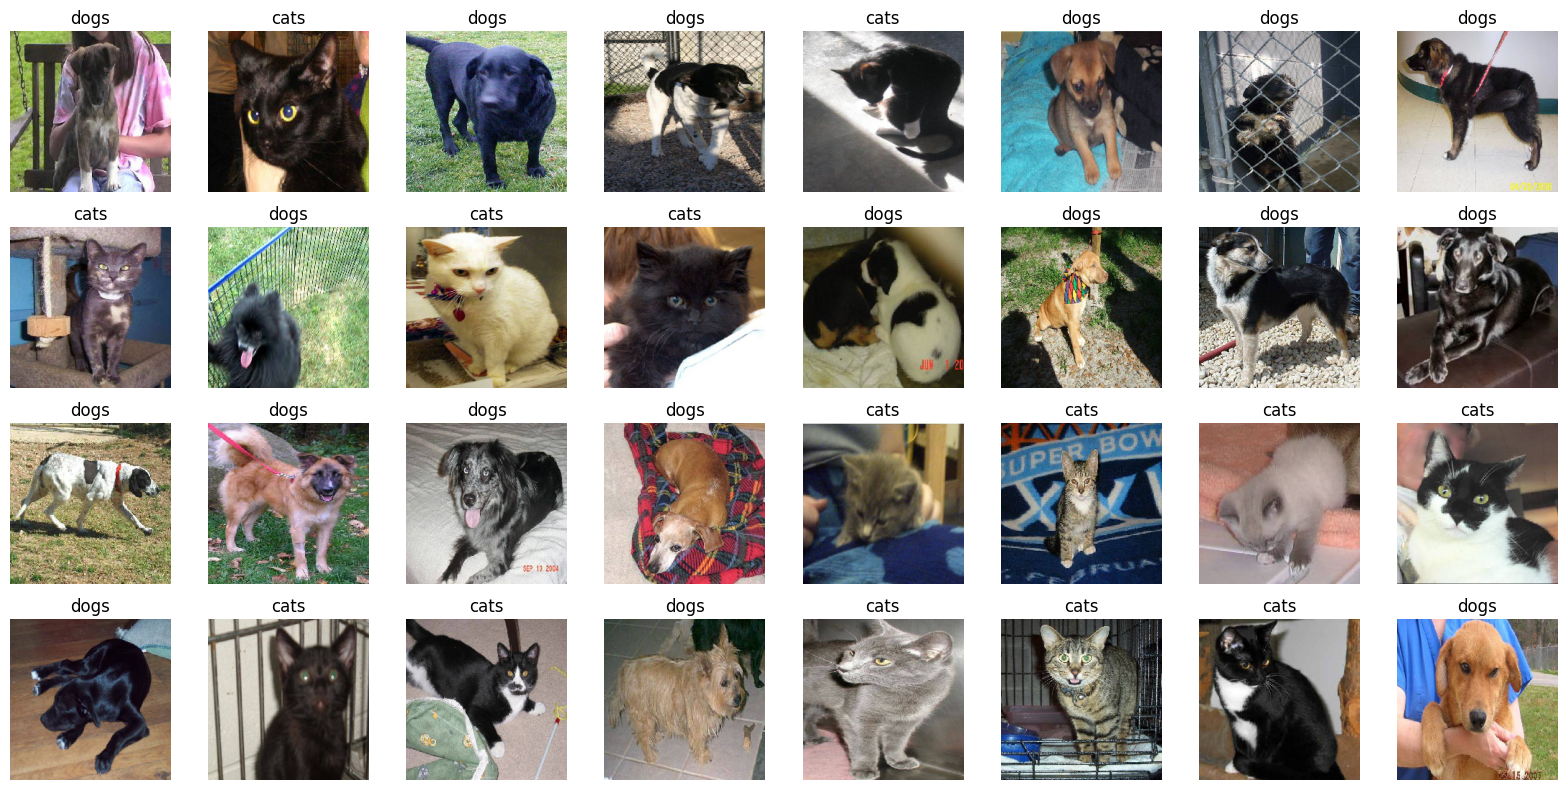

In [ ]:
# 샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):

    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis("off")
plt.tight_layout()
plt.show()

**| 5-2-3 모델 훈련**
- '배치 정규화-합성곱-풀링'으로 구성된 단위블럭을 3개 반복하여 이미지로부터 다양한 피처를 추출하고, 최종 분류기로는 dense 레이어 사용
- 최종 출력 레이어는 노드 1개를 갖고 활성화 함수로는 'sigmoid' 적용

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model

model = build_model()

> - 옵티마이저, 손실함수를 지정
- 모델을 컴파일하고, 20 epoch 동안 훈련
    + 그 결과, 훈련 셋에 대한 정확도는 92%, 검증 셋에 대한 정확도는 79% 수준으로 과대적합 발생

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

**코드 안돌아감/ 훈련 셋 정확도 92%, 검증셋 정확도 79%**

> - 손실함수 그래프를 그려보면 과대적합이 빠르게 발생한 것을 알 수 있음

In [ ]:
# 손실함수, 정확도 그래프 그리기

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

In [ ]:
plot_loss_acc(history, 20)

**코드 안돌아감**
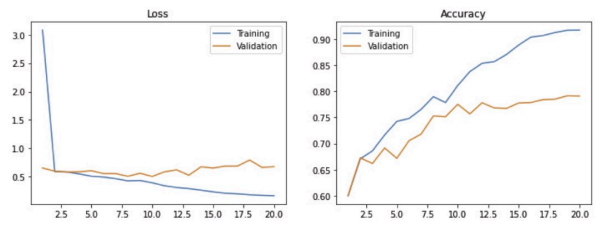

**| 5-2-4 데이터 증강**
- ImageDataGenerator: 다양한 데이터 증강 기버븡ㄹ 클래스 함수의 매개변수 속성으로 지정할 수 있어서 편리하다는 장점이 있음
  + horizontal_flip 속성 지정(좌우반전), 회전 최대 30도 지정
  + shear_range 속성(반시계 방향으로 밀기), zoom_range 속성(줌으로 확대) 추가

- epoch를 40까지 늘려 다시 모델 훈련 수행
  + 과대적합이 발생하지 않고 약 85% 수준의 정확도

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip=True,
                                   rotation_range=35,
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

**코드 안돌아감/ 정확도 약 85%**

- 손실함수와 모델의 정확도 그래프 생성
  + 과대적합이나 과소적합이 거의 발생하지 않고 학습이 잘 진행되는 것을 확인 가능

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history_aug, 20)

**코드 안돌아감**
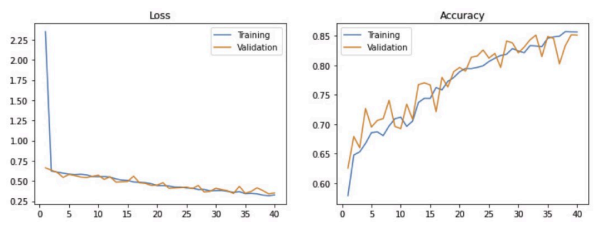

## **06. 객체 탐지**
- 객체 탐지: 입력 이미지로부터 여러 개의 객체를 찾아내고 각 객체가 무엇을 나타내는지 분류하는 두 가지 작업을 처리하는 과정
  + 객체의 위치를 찾아내고 객체를 둘러싸는 네모 박스를 그리는데, 객체의 경계를 나타내는 좌표 값을 회귀 문제로 접근


### **6-1 텐서플로 허브 활용**
- 텐서플로 허브: 이미지 분류, 객체 탐지, 스타일 전이, 텍스트 분류 등 다양한 딥러닝 문제를 해결할 수 있는 검증된 사전 학습 모델을 제공하는 저장소
  + 제공하는 모델을 그대로 배포하여 서빙하거나 전이 학습을 거쳐 개별 도메인에 맞게 튜닝한 다음 배포하는 것도 가능

In [3]:
import tensorflow as tf  # tensorflow
import tensorflow_hub as tfhub  # tensorflow hub

**| 6-1-1 샘플 이미지 준비**
- 이미 학습된 딥러닝 모델을 사용하여 별도의 모델 학습이 필요하지 않음
- 위키피디아에서 제공하는 서울 강남 지역의 거리 사진을 다운로드 받아서 모델의 입력 형태에 맞게 전처리

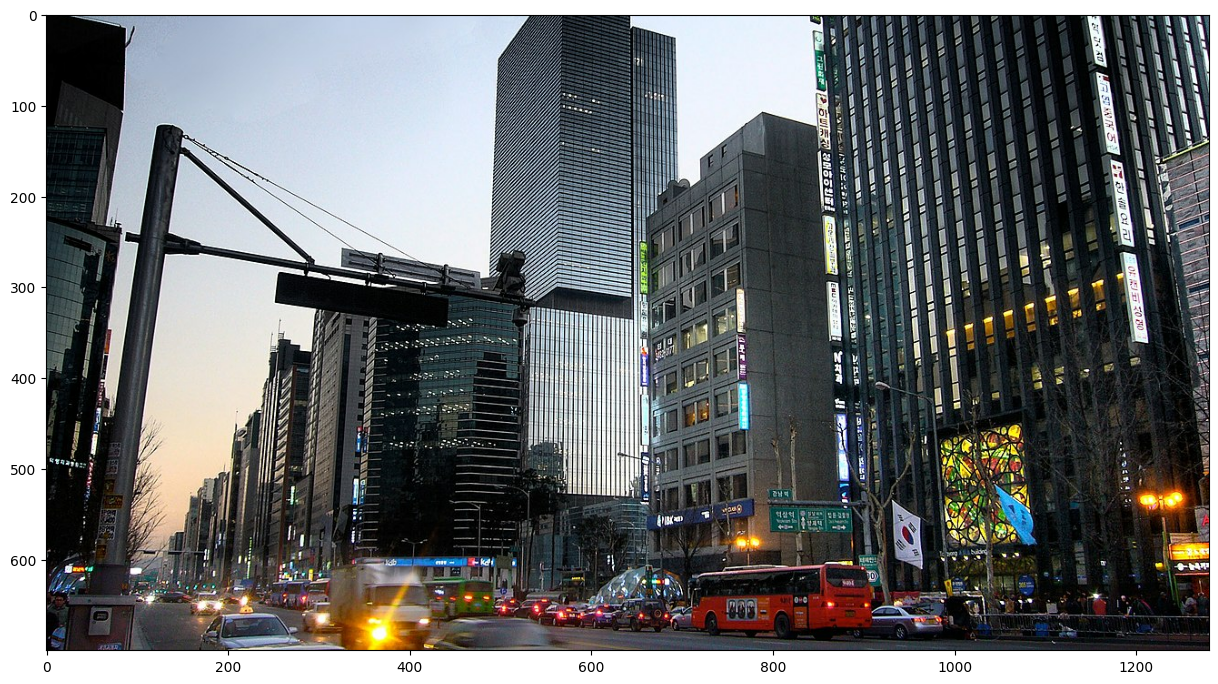

In [4]:
# 샘플 이미지 다운로드
img_path = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg'
img = tf.keras.utils.get_file(fname='gangnam', origin=img_path)
img = tf.io.read_file(img)   # 파일 객체를 string으로 변환
img = tf.image.decode_jpeg(img, channels=3)   # 문자(string)를 숫자(unit8) 텐서로 변환
img = tf.image.convert_image_dtype(img, tf.float32)   # 0 ~ 1 범위로 정규화

import matplotlib.pylab as plt
plt.figure(figsize=(15, 10))
plt.imshow(img)

- 사전 학습 모델은 배치 크기를 포함하여 4차원 텐서를 입력으로 받음
  + 0번 축으로 새로운 축 추가

In [5]:
img_input = tf.expand_dims(img, 0)  # batch_size추가
img_input.shape

TensorShape([1, 700, 1280, 3])

**| 6-1-2 사전 학습 모델**
- 텐서플로 허브에서 Open Images v4 데이터셋으로 사전에 학습된 2가지 모델 제공
  + Faster R-CNN 알고리즘으로 구현된 inception_resnet_v2 모델 사용

In [6]:
# TensorFlow Hub에서 모델 가져오기 - FasterRCNN+InceptionResNet V2
model = tfhub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")

> - 모델의 시그니처 확인
    + 'default' 시그니처 하나 제공

In [7]:
# 모델 시그니처(용도) 확인
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7EFC9468AE30>}))

> - 모델에서 'default' 시그니처를 지정하여 객체 탐지 모델 인스턴스 생성

In [8]:
# 객체탐지 모델 생성
obj_detector = model.signatures['default']
obj_detector

<ConcreteFunction pruned(images) at 0x7EFC9468AE30>

**| 6-1-3 추론**
- 객체 탐지 모델에 앞에서 미리 전처리를 통해 준비한 샘플 이미지 입력
- 모델은 추론을 거쳐서 예측 값을 반환

In [9]:
# 모델을 이용하여 예측 (추론)
result = obj_detector(img_input)
result.keys()

dict_keys(['detection_class_entities', 'detection_class_names', 'detection_class_labels', 'detection_boxes', 'detection_scores'])

> - 다음 값 사용 예정
    + detection_boxes: 경계 박스 좌표
    + detection_class_entities: 검출된 클래스 아이디
    + detection_scores: 검출 스코어
  - 검출 스코어 점수의 개수를 통해서 100개의 객체 탐지한 것을 알 수 있음

In [10]:
# 탐지한 객체의 개수
len(result["detection_scores"])

100

> - 검출된 100개의 객체 중에서 검출 스코어가 0.1보다 큰 경우만 경계 박스와 예측 클래스를 시각화
    + 최대 10개 객체만 표시되도록 설정

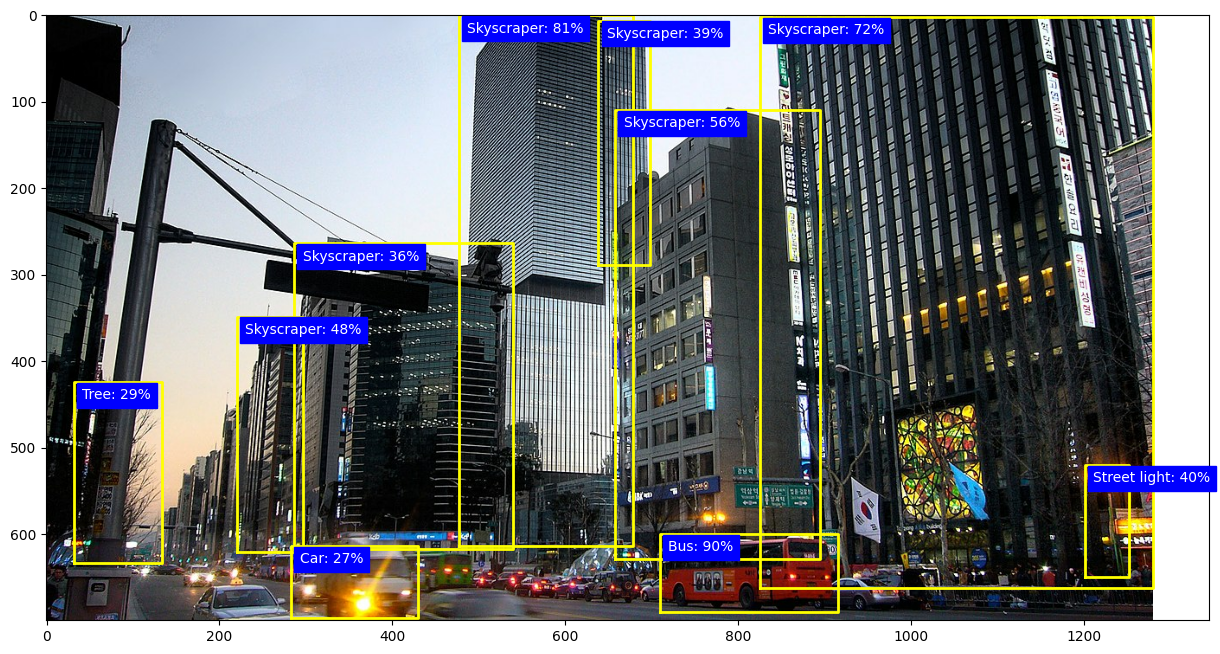

In [11]:
# 객체 탐지 결과를 시각화
boxes = result["detection_boxes"]    # Bounding Box 좌표 예측값
labels = result["detection_class_entities"]   # 클래스 값
scores = result["detection_scores"]   # 신뢰도 (confidence)

# 샘플 이미지 가로 세로 크기
img_height, img_width = img.shape[0], img.shape[1]

# 탐지할 최대 객체의 수
obj_to_detect = 10

# 시각화
plt.figure(figsize=(15, 10))
for i in range(min(obj_to_detect, boxes.shape[0])):
    if scores[i] >= 0.2:
        (ymax, xmin, ymin, xmax) = (boxes[i][0]*img_height, boxes[i][1]*img_width,
                                    boxes[i][2]*img_height, boxes[i][3]*img_width)

        plt.imshow(img)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],
                 color='yellow', linewidth=2)

        class_name = labels[i].numpy().decode('utf-8')
        infer_score = int(scores[i].numpy()*100)
        annotation = "{}: {}%".format(class_name, infer_score)
        plt.text(xmin+10, ymax+20, annotation,
                 color='white', backgroundcolor='blue', fontsize=10)

### **6-2 YOLO 객체 탐지**
- 이번에는 Darknet에서 제공하는 YOLO 객체 탐지 모델 사용
- YOLO: 경계 박스와 예측 클래스를 서로 다른 문제로 다루지 않고 하나의 회귀 문제로 접근하는 개념
  + 하나의 신경망이 한 번만 계산해 두 가지 일을 한꺼번에 처리하여 속도가 매우 빠르다는 장점을 가짐

**| 6-2-1 Darknet YOLO 모델 추론하기**
- YOLO 모델을 개인의 로컬 PC 환경에서 학습하는 것은 사실상 불가능
  + 성능 좋은 GPU 필요하고, 학습시간도 오래 걸림
  + Darknet에서 제공하는 사전 학습 모델을 활용하면 일반 PC 환경에서도 다양한 딥러닝 모델 실행 가능
- 먼저 Alexey Bochkoviskiy의 깃허브 저장소를 코랩환경으로 다운로드 받아 darknet 폴더가 생성되는 것을 확인
- 객체를 탐지할 이미지 업로드

In [12]:
# 깃헙 저장소 복제
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


> - GPU를 사용할 수 있도록 Darknet의 Makefile 수정 후 Darknet 생성

In [13]:
# GPU 활성화
%cd darknet
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

# Darknet 생성
!make

/content/darknet
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sender::write(const char*)’:
./src/http_stream.cpp:253:21: warning: unused variable ‘n’ [-Wunused-variable]
  253 |                 int n = _write(client, outputbuf, outlen);
      |                     ^
./src/http_stream.cpp: In function ‘void set_track_id(detection*, int, float, float, float, int, int, int)’:
./sr

In [14]:
# 모델 가중치 가져옴
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3

--2023-06-16 11:12:59--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-06-16 11:12:59 ERROR 404: Not Found.



> - 업로드한 샘플 이미지를 출력 후 확인

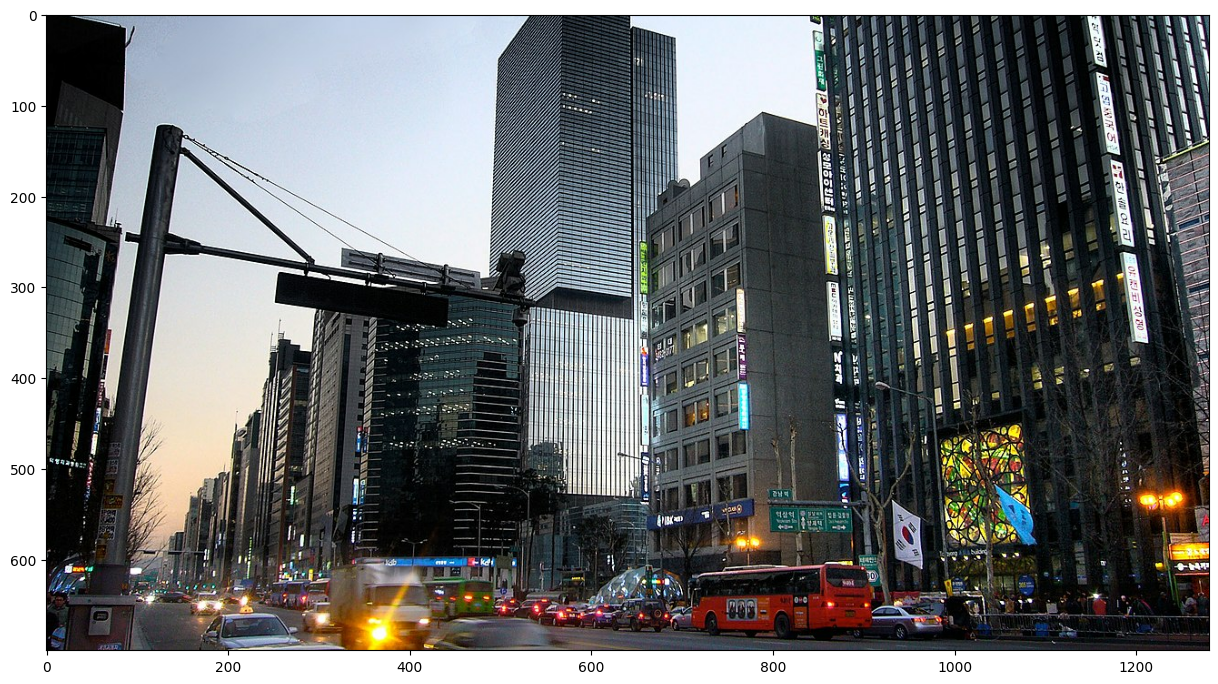

In [15]:
import matplotlib.pylab as plt
import tensorflow as tf

plt.figure(figsize=(15, 10))
img = tf.io.read_file('/content/gangnam.jpg')
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
plt.imshow(img)

> - Darknet을 실행하여 샘플 이미지에 대한 객체 탐지를 추론
 - 객체를 추출하고 예측 확률을 계산
 - 샘플 이미지의 코랩 파일 경로를 마지막에 추가

In [16]:
# Darknet 실행
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights /content/gangnam.jpeg # 노트북이라 GPU가 없어 결과 생략

./darknet: error while loading shared libraries: libcuda.so.1: cannot open shared object file: No such file or directory


> - 탐지한 결과는 darknet 폴더에 predicitions.jpg라는 이름으로 저장

In [17]:
plt.figure(figsize=(15, 10))
#img = tf.io.read_file('/content/darknet/predictions.jpg')
#img = tf.image.decode_jpeg(img, channels=3)
#img = tf.image.convert_image_dtype(img, tf.float32)   #
#plt.imshow(img)

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

**| 6-2-2 나만의 YOLO 모델 생성**
- 검은색 바탕에 간단한 도형 3개만 탐지하는 YOLO 모델을 만들어보고, 모델을 쉽게 이해
- YOLO논문에서는 이미지를 가로, 세로 각각 7개의 셀로 나누어 총 49 셀을 기본으로 하지만, 각각 3개의 셀로 나누는 ㅂ아식으로 문제를 단순화
- 논문에서는 한 셀 당 2개의 박스를 그리지만, 한 셀 당 1개의 박스를 그리는 방식으로 수정
- 탐지할 객체의 종류인 Class도 3개로 줄여서 구현

In [24]:
# 필요한 패키지를 임포트 함
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# 파라미터 설정

# 이미지 크기
width_size = 256
height_size = 256
channel_size = 3
img_size = (width_size,hight_size,channel_size)

# 이미지를 나눌 크기
cell_num = 3

# 찾고자 하는 객체 개수
class_num = 3

# 한셀에 그릴 박스 수
anchor_num = 1
label_num = anchor_num * (5 + class_num)

# 학습 수
epoch_num = 20000

# 로스 비중
loss_p_rate = 1.0
loss_cod_rate = 5.0
loss_c_rate = 1.0
loss_p_no_rate = 0.5

> - 실습을 위해 자료실에서 제공하는 3개의 이미지 파일 사용
- CV2를 이용하여 랜덤한 위치에 3개의 도형 이미지를 그리고 이미지의 위치를 찾아 경계 박스로 나타낸 후 정답 클래스 레이블까지 반환하는 함수 정의

In [25]:
# 랜덤하게 도형을 그리고, 실제 정답 값을 생성하는 함수 정의
# 0.png / 1.png / 2.png 파일이 필요함

def make_img_label():
    img = np.zeros((height_size + 400, width_size + 400, channel_size))
    label = np.zeros((cell_num, cell_num, label_num))
    num_shape = np.random.randint(1,4)
    i = np.random.choice(range(cell_num), num_shape, replace=False)
    j = np.random.choice(range(cell_num), num_shape, replace=False)

    img_0 = cv2.imread('/content/0.png')
    img_1 = cv2.imread('/content/1.png')
    img_2 = cv2.imread('/content/2.png')

    for n_h in range(num_shape):
        row = i[n_h]
        col = j[n_h]
        shape_type = np.random.randint(0, class_num)
        x_rate = np.random.rand()
        y_rate = np.random.rand()
        w_rate = np.random.rand() * 0.3 + 0.1
        h_rate = np.random.rand() * 0.3 + 0.1

        label[row, col] = [1, x_rate, y_rate, w_rate, h_rate, 0, 0, 0]
        label[row, col, 5 + shape_type] = 1
        x = int(x_rate * width_size / cell_num + col * width_size / cell_num)
        y = int(y_rate * height_size / cell_num + row * height_size / cell_num)
        w = int(w_rate * width_size / 2) * 2
        h = int(h_rate * height_size / 2) * 2
        if(shape_type == 0):
            input_img = cv2.resize(img_0, (w,h))
        if(shape_type == 1):
            input_img = cv2.resize(img_1, (w,h))
        if(shape_type == 2):
            input_img = cv2.resize(img_2, (w,h))
        img[y-int(h/2)+200 : y+int(h/2)+200, x-int(w/2)+200 : x+int(w/2)+200] = input_img
    img = img[200 : 200+height_size, 200 : 200+width_size]

    return img, label

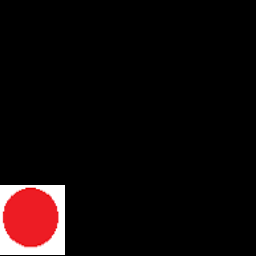

In [26]:
img, label = make_img_label()
cv2_imshow(img)

> - 앞에서 생성한 이미지와 클래스를 입력해 주면, 탐지한 이미지에 박스를 그려주는 함수를 정의
- 함수를 실행하면 경계 박스를 찾아서 표시

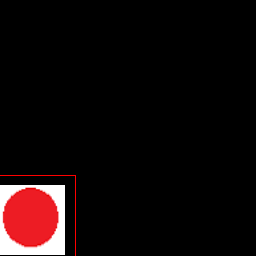

In [27]:
# 이미지와 정답(혹은 예측값)을 넣으면 박스를 그려주는 함수 정의
# 임계값 th 설정 (객체가 있다는 확률이 th이상일 때만 박스 생성)
def show_box(img,label,th=0.3):
    b_img = np.zeros((hight_size+400,width_size+400,3))
    b_img[200:200+hight_size,200:200+width_size] = img
    for i in range(cell_num):
        for j in range(cell_num):
            if(label[i,j,0] > th):
                x_rate = label[i,j,1]
                y_rate = label[i,j,2]
                w_rate = label[i,j,3]
                h_rate = label[i,j,4]
                shape_type=np.argmax(label[i,j,5:])
                if(shape_type==0):
                    line_color = [0,0,255]
                if(shape_type==1):
                    line_color = [255,0,0]
                if(shape_type==2):
                    line_color = [0,255,0]
                x = int(x_rate * width_size/3 + j * width_size/3)
                y = int(y_rate * hight_size/3 + i * hight_size/3)
                w = int(w_rate * width_size/2) * 2 + 20
                h = int(h_rate * hight_size/2) * 2 + 20

                cv2.rectangle(b_img,(x-int(w/2)+200,y-int(h/2)+200),(x+int(w/2)+200,y+int(h/2)+200),line_color)

    b_img = b_img[200:200+hight_size,200:200+width_size]
    return b_img
cv2_imshow(show_box(img,label))

> - 객체 탐지 모델의 어느 정도 성능을 갖기 위해서는 복잡한 구조로 구현되어야 함
- 전이 학습 방법을 적용하여 이미지 특징을 추출하는데 좋은 성능을 갖는 모델을 기본으로 활용하는 것이 좋음

- VGG16 모델을 베이스로 사용하고, Conv2D 층과 Dense 레이어를 마지막 객체 탐지 분류기로 수정 후 모델 구조를 요약하여 확인

In [28]:
# VGG16모델을 베이스로 마지막 부분만 수정하는 모델 생성 (전이 학습)
vgg_model = tf.keras.applications.VGG16(include_top=False,input_shape=img_size)
vgg_model.trainable=False
i=tf.keras.Input(shape=img_size)
out=tf.keras.layers.Lambda((lambda x : x/255.))(i)
out = vgg_model(out)
out = tf.keras.layers.Conv2D(256,3,padding='same')(out)
out = tf.keras.layers.Conv2D(128,3,padding='same')(out)
out = tf.keras.layers.Conv2D(64,3,padding='same')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(1024,activation='relu')(out)
out = tf.keras.layers.Dense(3*3*8,activation='sigmoid')(out)
out = tf.keras.layers.Reshape((3,3,8))(out)
yolo_model = tf.keras.Model(inputs=[i],outputs=[out])
opt = tf.keras.optimizers.Adam(0.00001)

# 모델 요약
yolo_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                              

> - 이미지를 총 9개의 셀로 나누고 셀마다 학습 진행
- 각 Loss는 미리 정한 비중을 곱하고 전체를 더해 최종 Loss를 만들어 모델 학습

In [ ]:
# 학습과정을 동영상으로 기록
fcc=cv2.VideoWriter_fourcc(*'DIVX')
out=cv2.VideoWriter('hjk_yolo.avi',fcc,1.0,(width_size,hight_size))
for e in range(epoch_num):
    img,label = make_img_label()
    img = np.reshape(img,(1,hight_size,width_size,3))
    label = np.reshape(label,(1,3,3,8))
    loss_p_list=[]
    loss_cod_list = []
    loss_c_list = []
    loss_p_no_list = []
    with tf.GradientTape() as tape:
        pred = yolo_model(img)
        # 이미지를 구분한 셀을 탐험
        for i in range(3):
            for j in range(3):
                # 해당 셀에 객체가 있을 경우는 확률, 박스 크기, 클래스까지 모두 Loss로 계산
                if(label[0,i,j,0]==1):
                    loss_p_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
                    loss_cod_list.append(tf.square(label[0,i,j,1]-pred[0,i,j,1]))
                    loss_cod_list.append(tf.square(label[0,i,j,2]-pred[0,i,j,2]))
                    loss_cod_list.append(tf.square(label[0,i,j,3]-pred[0,i,j,3]))
                    loss_cod_list.append(tf.square(label[0,i,j,4]-pred[0,i,j,4]))
                    loss_c_list.append(tf.square(label[0,i,j,5]-pred[0,i,j,5]))
                    loss_c_list.append(tf.square(label[0,i,j,6]-pred[0,i,j,6]))
                    loss_c_list.append(tf.square(label[0,i,j,7]-pred[0,i,j,7]))
                # 해당 셀에 객체가 없을 경우 객체가 없을 확률만 Loss로 계산
                else:
                    loss_p_no_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
        loss_p=tf.reduce_mean(loss_p_list)
        loss_cod =tf.reduce_mean(loss_cod_list)
        loss_c = tf.reduce_mean(loss_c_list)
        loss_p_no = tf.reduce_mean(loss_p_no_list)
        # 각 Loss를 비중을 곱해 더해 최종 Loss를 계산
        loss = loss_p_rate * loss_p + loss_cod_rate * loss_cod + loss_c_rate * loss_c + loss_p_no_rate * loss_p_no
    # Loss에 대한 Grad를 구하고, 각 파라미터를 업데이트
    vars = yolo_model.trainable_variables
    grad = tape.gradient(loss, vars)
    opt.apply_gradients(zip(grad, vars))
    # 100번 마다 동영상에 이미지를 기록한다
    if(e%100==0):
        img = np.reshape(img,(256,256,3))
        label = pred.numpy()
        label = np.reshape(label,(3,3,8))
        sample_img = np.uint8(show_box(img,label))
        out.write(sample_img)
    print(e,"완료",loss.numpy())
out.release()

> - 학습 과정은 동영상 파일로 저장, 코랩 폴더에서 동영상 파일을 로컬 PC로 다운로드
  + 동영상을 실행해 학습 과정을 보면 약 10000번 학습이 이루어지고 난 뒤부터는 객체 탐지를 어느 정도 수준에서는 잘 해내는 것을 확인 가능